In [209]:
import flickrapi
from IPython.display import HTML, Image, display
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
import os
import multiprocessing
from sklearn.model_selection import train_test_split  
from functools import partial
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
from glob import glob
from sklearn import svm
import numpy.linalg

In [6]:
# Remove before publishing:
FLICKR_KEY = 'c9511f1328036f0ae49f0538dedff432'
FLICKR_SECRET = '892eb48de6cc87e1'

In [7]:
flickr = flickrapi.FlickrAPI(FLICKR_KEY, FLICKR_SECRET, format='parsed-json')

In [ ]:
def flickr_url(photo, size=''):
    url = 'http://farm{farm}.staticflickr.com/{server}/{id}_{secret}{size}.jpg'
    if size:
        size = '_' + size
    return url.format(size=size, **photo)

In [194]:
res = flickr.photos.search(text='"cat"', per_page='10', sort='relevance')
photos = res['photos']['photo']
tags = ['<img src="{}" width="150" style="display:inline"/>'.format(flickr_url(photo)) for photo in photos]
HTML(''.join(tags))

In [197]:
def fetch_photo(dir_name, photo):
    urlretrieve(flickr_url(photo), os.path.join(dir_name, photo['id'] + '.jpg'))

def fetch_image_set(query, dir_name=None, count=250, sort='relevance'):
    res = flickr.photos.search(text='"{}"'.format(query), 
                               per_page=count, sort=sort)['photos']['photo']
    dir_name = dir_name or query
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    with multiprocessing.Pool() as p:
        p.map(partial(fetch_photo, dir_name), res)


In [111]:
fetch_image_set('cat')
fetch_image_set('dog')

In [100]:
model = VGG16(weights='imagenet', include_top=True)

1165

In [121]:
images = [image.load_img(p, target_size=(224, 224)) 
          for p in glob('cat/*jpg') + glob('dog/*jpg')]
tensor = np.asarray([image.img_to_array(img) for img in images])

In [127]:
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [128]:
p = model.predict(tensor)

In [181]:
X_train, X_test, y_train, y_test = train_test_split(p, [1] * 250 + [0] * 250, test_size=0.20, random_state=42)

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
sum(1 for p, t in zip(clf.predict(X_test), y_test) if p != t)

12

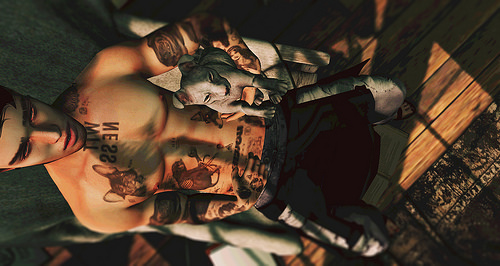

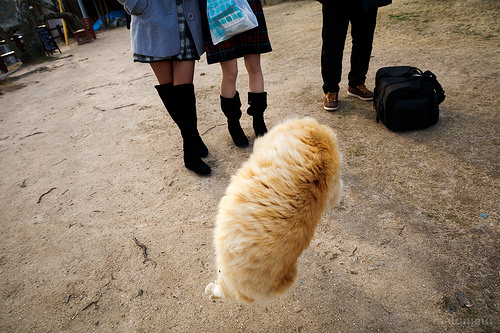

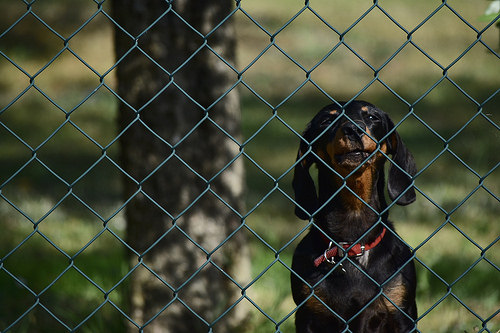

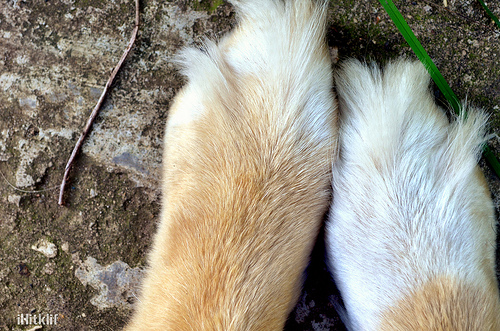

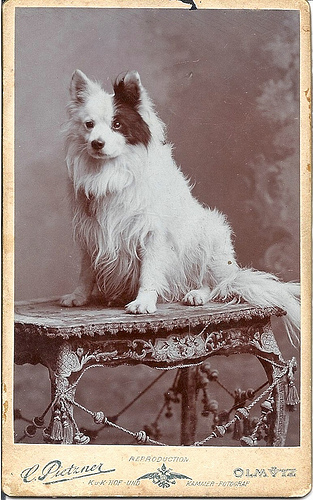

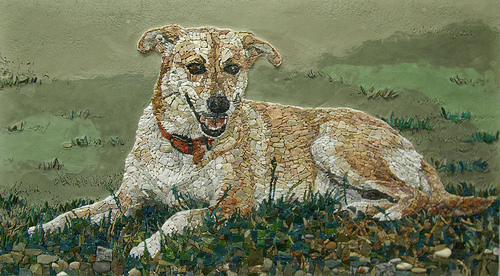

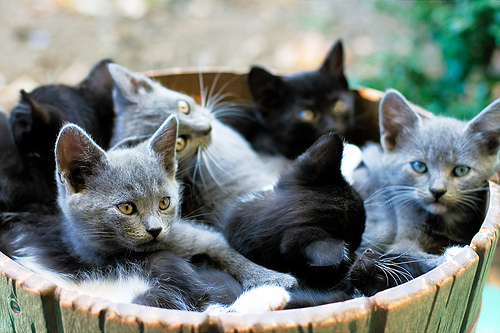

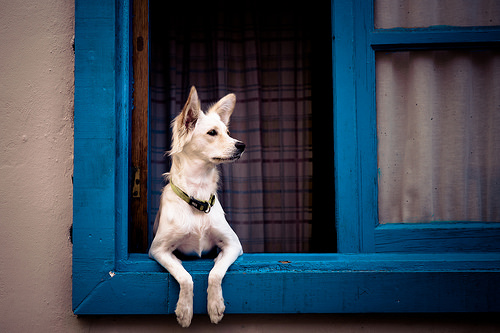

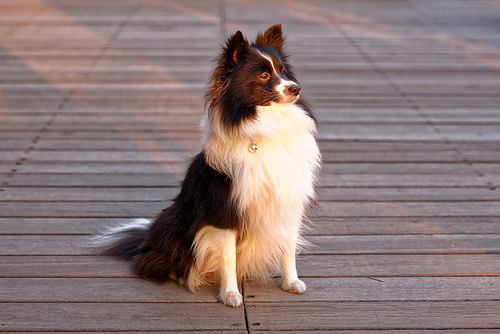

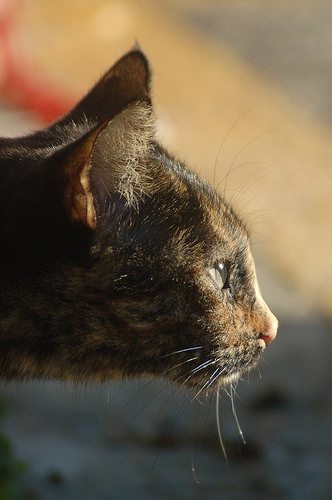

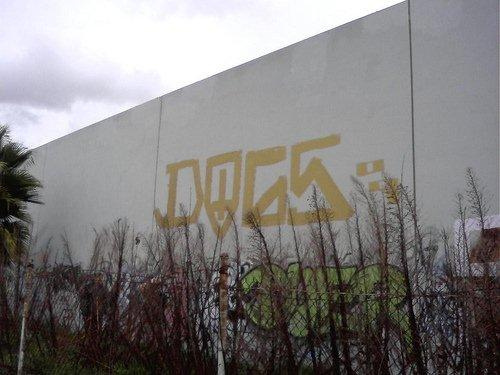

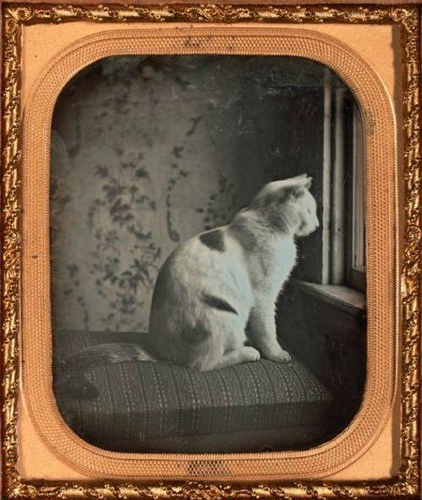

In [184]:
mm = {tuple(a): b for a, b in zip(p, glob('cat/*jpg') + glob('dog/*jpg'))}
wrong = [mm[tuple(a)] for a, p, t in zip(X_test, clf.predict(X_test), y_test) if p != t]

for x in wrong:
    display(Image(x, width=150))

In [199]:
fetch_image_set('cat', dir_name='maybe_cat', count=100, sort='recent')

In [200]:
maybe_cat_fns = glob('maybe_cat/*jpg')
maybe_cats = [image.load_img(p, target_size=(224, 224)) 
              for p in maybe_cat_fns]
maybe_cat_tensor = np.asarray([image.img_to_array(img) 
                              for img in maybe_cats])
maybe_cat_vectors = model.predict(maybe_cat_tensor)

In [205]:
centroid = maybe_cat_vectors.sum(axis=0) / len(maybe_cats)
centroid

array([ 0.69166255,  0.4298178 ,  0.80347246, ...,  0.42679417,
        1.00465953,  0.77856803], dtype=float32)

In [229]:
diffs = maybe_cat_vectors - centroid
distances = numpy.linalg.norm(diffs, axis=1)

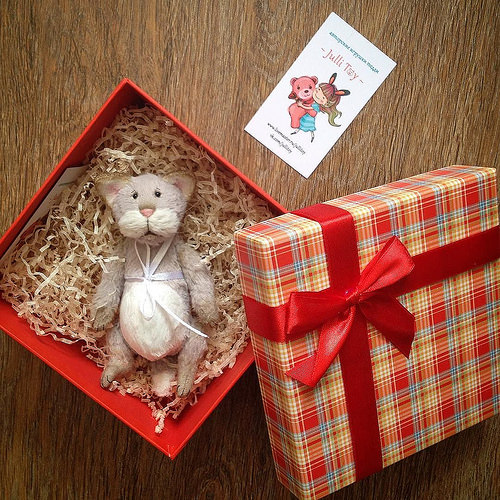

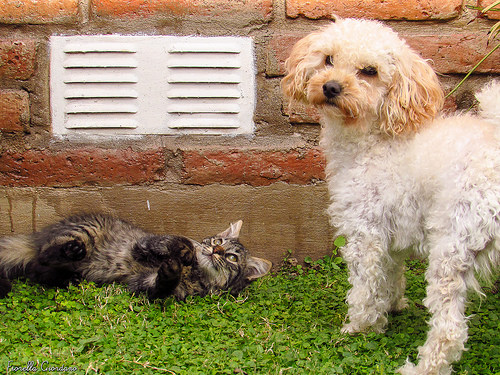

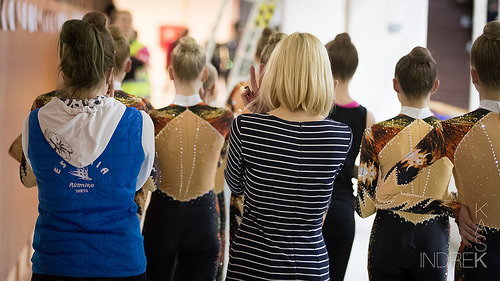

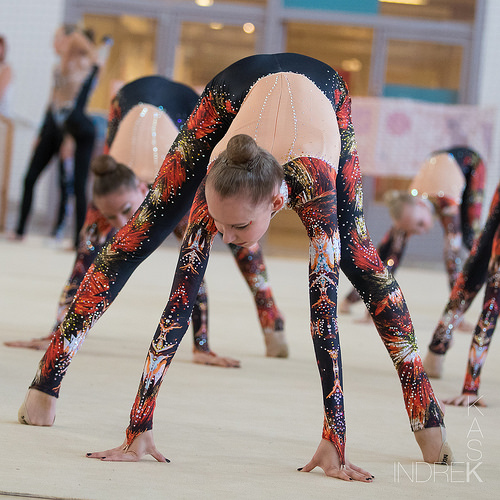

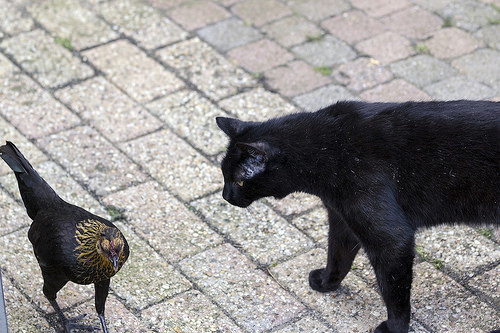

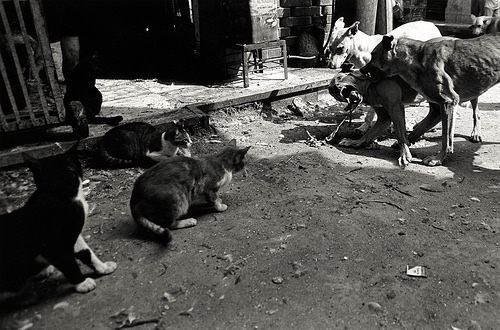

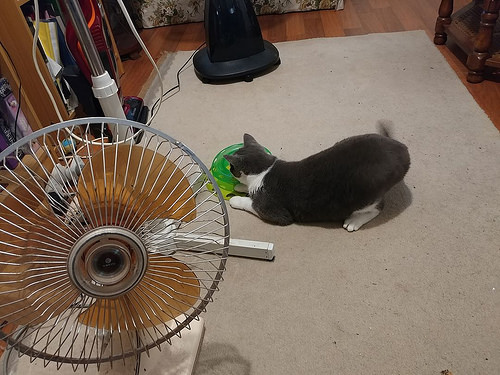

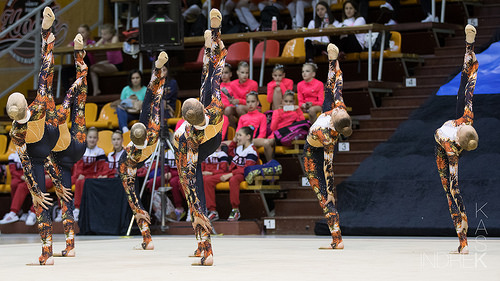

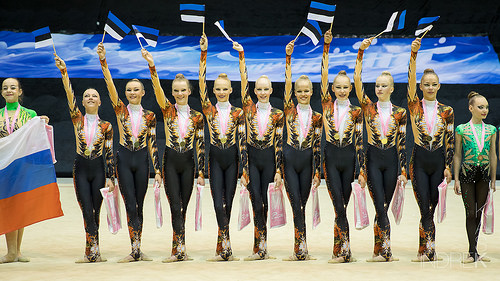

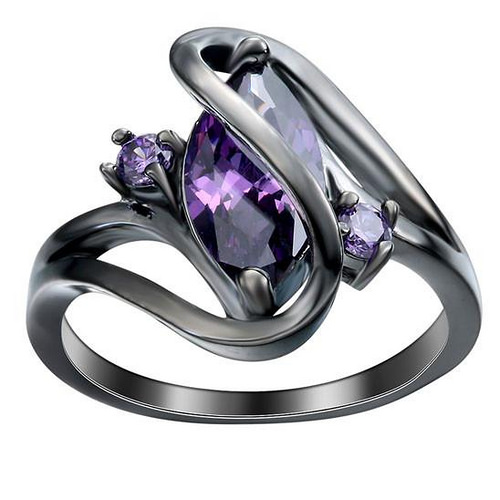

In [232]:
sorted_idxs = np.argsort(distances)
for worst_cat_idx in sorted_idxs[-10:]:
    display(Image(maybe_cat_fns[worst_cat_idx], width=150))

In [263]:
to_drop = 90
sorted_idxs_i = sorted_idxs
for i in range(5):
    centroid_i = maybe_cat_vectors[sorted_idxs_i[:-to_drop]].sum(axis=0) / (len(maybe_cat_fns) - to_drop)
    distances_i = numpy.linalg.norm(maybe_cat_vectors - centroid_i, axis=1)
    sorted_idxs_i = np.argsort(distances_i)


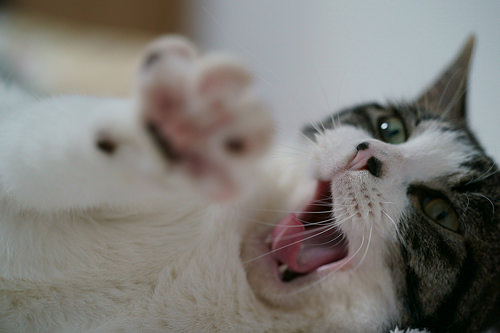

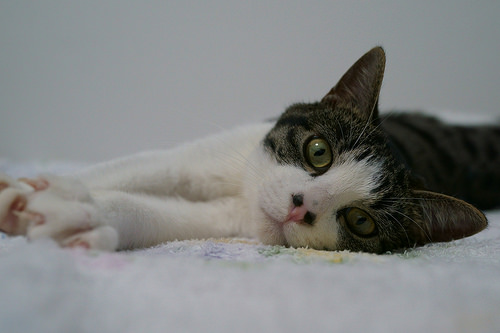

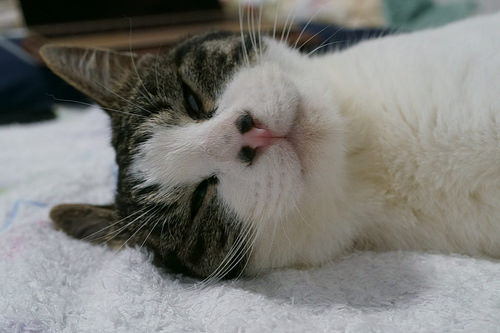

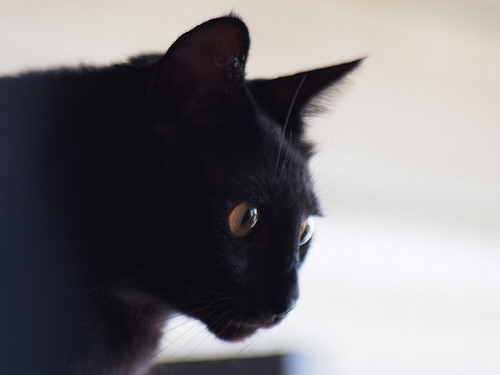

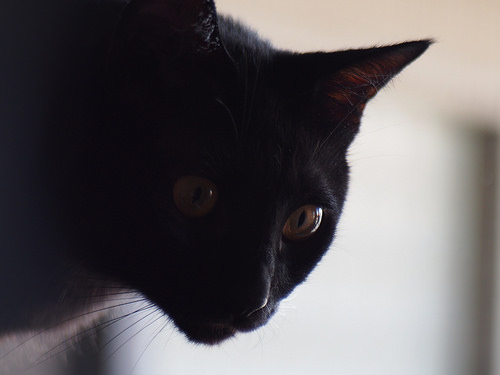

In [265]:
for worst_cat_idx in sorted_idxs_i[:5]:
    display(Image(maybe_cat_fns[worst_cat_idx], width=150))